# Assignment 6: Genetic Algorithm for the Travelling Salesman Problem (TSP)
## Name : Uttam Mahata
## Enrollment No : 2022CSB104

### Objective: 
To apply a Genetic Algorithm (GA) to solve the Travelling Salesman Problem by finding the
shortest route that visits each city exactly once and returns to the starting point.

### Problem Statement: 
The Travelling Salesman Problem (TSP) is a classic optimization problem. Given a set of cities
and the distances between every pair of cities, the objective is to determine the shortest possible
route that visits every city exactly once and returns to the origin city.

#### Given:
- **$ N $**: Number of cities.
- **$ D_{i,j} $**: Distance between city $ i $ and city $ j $, where $ i, j \in \{1, 2, ..., N\} $.

#### 1. Initial Population ($ P(0) $)
- Define an initial population $ P(0) $ consisting of $ M $ routes.
- Each route is represented as a permutation $ C_k $ of the set of cities $ \{1, 2, ..., N\} $, such that:
$$
C_k = [c_{k1}, c_{k2}, ..., c_{kN}], \quad \text{where } c_{ki} \text{ represents the index of the city in position } i \text{ of the route } k.
$$

#### 2. Fitness Function ($ F $)
- The fitness $ F(C_k) $ for a route $ C_k $ is defined as the inverse of the total distance of the route:
$$
\text{Total Distance of Route } C_k = \sum_{i=1}^{N-1} D_{c_{ki}, c_{k(i+1)}} + D_{c_{kN}, c_{k1}}
$$
$$
F(C_k) = \frac{1}{\text{Total Distance of } C_k}
$$
- The higher the fitness, the better the route.

#### 3. Selection Process
- Select individuals from the population $ P(t) $ to become parents for the next generation using a selection method such as **roulette wheel selection** or **tournament selection**:
    - **Roulette Wheel Selection**: Assign a probability $ p_k $ to each individual based on its fitness:
    $$
    p_k = \frac{F(C_k)}{\sum_{j=1}^{M} F(C_j)}
    $$
    - **Tournament Selection**: Randomly select $ T $ individuals from $ P(t) $ and choose the one with the highest fitness as a parent.

#### 4. Crossover (Recombination)
- Apply crossover to selected parents with a probability $ p_{crossover} = 0.6 $.
- Use a permutation-based crossover method such as **Order Crossover (OX)**:
    - Given two parents $ C_p = [c_{p1}, ..., c_{pN}] $ and $ C_q = [c_{q1}, ..., c_{qN}] $, create offspring by:
        - Selecting a random subsequence from $ C_p $.
        - Filling in the remaining cities from $ C_q $ while preserving their order and avoiding duplicates.
- Mathematically, if:
$$
\text{Crossover point indices } i_1 \text{ and } i_2 \text{ are chosen such that } 1 \leq i_1 < i_2 \leq N,
$$
then:
$$
\text{Offspring } C_{offspring} = [c_{p1}, ..., c_{pi_1}, c_{qi_1+1}, ..., c_{qi_2}, c_{p(i_2+1)}, ..., c_{pN}]
$$

#### 5. Mutation
- Introduce mutations with a probability $ p_{mutation} = 0.1 $ to maintain genetic diversity.
- Use **swap mutation**:
    - Select two random cities $ i $ and $ j $ in a route $ C_k $ such that $ i \neq j $.
    - Swap the cities to create a new route $ C_k' $:
$$
C_k' = [c_{k1}, ..., c_{ki-1}, c_{kj}, c_{ki+1}, ..., c_{kj-1}, c_{ki}, c_{kj+1}, ..., c_{kN}]
$$

#### 6. Algorithm Flow
- **Initial Population**:
    $$
    P(0) = \{C_1, C_2, ..., C_M\}
    $$

- **Iteration for each generation**:
    1. Evaluate fitness $ F(C_k) $ for all $ C_k \in P(t) $.
    2. Select parents $ P_{parents}(t) $ from $ P(t) $ using the selection method.
    3. Apply crossover to generate offspring $ P_{offspring}(t) $.
    4. Apply mutation to $ P_{offspring}(t) $ to introduce genetic diversity.
    5. Form the next generation:
    $$
    P(t+1) = P_{offspring}(t)
    $$

- **Repeat** until a termination condition is met (e.g., a fixed number of generations or convergence).

#### 7. Termination
- The algorithm terminates when:
    - A specified number of generations $ T_{max} $ is reached.
    - The solution converges such that the change in the best fitness over $ G $ generations is minimal.

### Notation Summary:
- $ C_k $: A route (permutation of cities).
- $ F(C_k) $: Fitness of route $ C_k $.
- $ D_{i,j} $: Distance between city $ i $ and city $ j $.
- $ M $: Population size.
- $ p_{crossover} $: Probability of crossover.
- $ p_{mutation} $: Probability of mutation.

### Implementation in Python

#### Dataset Preparation

In [5]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import pandas as pd
import time

# Initialize geolocator with an increased timeout
geolocator = Nominatim(user_agent="tsp-geolocator", timeout=10)

# Expanded list of major Indian cities
cities = [
    "Delhi", "Mumbai", "Bangalore", "Hyderabad", "Kolkata", "Chennai", "Pune", "Ahmedabad",
    "Jaipur", "Lucknow", "Surat", "Kanpur", "Nagpur", "Visakhapatnam", "Bhopal", "Patna",
    "Vadodara", "Agra", "Nashik", "Vijayawada", "Coimbatore", "Indore", "Thane", "Ludhiana",
    "Madurai", "Bhubaneswar", "Amritsar", "Varanasi", "Raipur", "Aurangabad", "Ranchi",
    "Jodhpur", "Guwahati", "Chandigarh", "Mysore", "Gwalior", "Noida", "Faridabad", "Ghaziabad",
    "Meerut", "Rajkot", "Dhanbad", "Jalandhar", "Kota", "Bareilly", "Bikaner", "Agartala",
    "Jammu", "Udaipur", "Dehradun", "Allahabad", "Srinagar", "Mangalore"
]

# Dictionary to store city coordinates
city_coordinates = {}

# Function to get coordinates with retry logic
def get_coordinates(city, retries=3):
    for attempt in range(retries):
        try:
            location = geolocator.geocode(city + ", India")
            if location:
                return (location.latitude, location.longitude)
            else:
                print(f"Coordinates for {city} not found.")
                return None
        except GeocoderTimedOut:
            print(f"Geocoder timed out for {city}, attempt {attempt + 1}/{retries}")
            time.sleep(2)  # Wait before retrying
    return None

# Get coordinates for each city
for city in cities:
    coordinates = get_coordinates(city)
    if coordinates:
        city_coordinates[city] = coordinates
        print(f"Coordinates for {city}: {coordinates}")
    else:
        print(f"Skipping {city} due to repeated timeout.")

# Convert to a DataFrame for easy handling
city_df = pd.DataFrame.from_dict(city_coordinates, orient='index', columns=['Latitude', 'Longitude'])
print("City Coordinates:")
print(city_df)

# Save city coordinates to a CSV file
city_df.to_csv('indian_cities_coordinates.csv', index_label='City')

# Confirm completion
print("Dataset preparation complete. Saved to 'indian_cities_coordinates.csv'.")


Coordinates for Delhi: (28.6273928, 77.1716954)
Coordinates for Mumbai: (19.054999, 72.8692035)
Coordinates for Bangalore: (12.9767936, 77.590082)
Coordinates for Hyderabad: (17.360589, 78.4740613)
Coordinates for Kolkata: (22.5726459, 88.3638953)
Coordinates for Chennai: (13.0836939, 80.270186)
Coordinates for Pune: (18.5213738, 73.8545071)
Coordinates for Ahmedabad: (23.0215374, 72.5800568)
Coordinates for Jaipur: (26.9154576, 75.8189817)
Coordinates for Lucknow: (26.8381, 80.9346001)
Coordinates for Surat: (21.2094892, 72.8317058)
Coordinates for Kanpur: (26.4609135, 80.3217588)
Coordinates for Nagpur: (21.1498134, 79.0820556)
Coordinates for Visakhapatnam: (17.7231276, 83.3012842)
Coordinates for Bhopal: (23.2584857, 77.401989)
Coordinates for Patna: (25.6093239, 85.1235252)
Coordinates for Vadodara: (22.2973142, 73.1942567)
Coordinates for Agra: (27.1752554, 78.0098161)
Coordinates for Nashik: (20.0112475, 73.7902364)
Coordinates for Vijayawada: (16.5087573, 80.6185089)
Coordinate

#### Distance Matrix Calculation

In [6]:
from geopy.distance import geodesic

# Function to calculate distance matrix
def calculate_distance_matrix(city_df):
    cities = city_df.index
    num_cities = len(cities)
    distance_matrix = pd.DataFrame(index=cities, columns=cities)
    
    for city1 in cities:
        for city2 in cities:
            if city1 == city2:
                distance_matrix.loc[city1, city2] = 0
            else:
                coord1 = (city_df.loc[city1, 'Latitude'], city_df.loc[city1, 'Longitude'])
                coord2 = (city_df.loc[city2, 'Latitude'], city_df.loc[city2, 'Longitude'])
                distance_matrix.loc[city1, city2] = geodesic(coord1, coord2).kilometers
    
    return distance_matrix

# Generate and save the distance matrix
distance_matrix = calculate_distance_matrix(city_df)
distance_matrix.to_csv('distance_matrix.csv')


#### Initial Population Generation



1. **Define the Set of Cities**:
   - Let $ C = \{ c_1, c_2, \dots, c_n \} $ be the set of cities, where $ n $ is the total number of cities.

2. **Objective**:
   - The task is to create an initial population of possible routes, each of which is a permutation of the cities in $ C $.

3. **Permutation of Cities (Route)**:
   - A route $ R $ is an ordered sequence of cities:
     $$
     R = (c_{\sigma(1)}, c_{\sigma(2)}, \dots, c_{\sigma(n)})
     $$
     where $ \sigma $ is a permutation of the indices $ \{1, 2, \dots, n\} $, meaning each city appears exactly once in the route $ R $.
   - The total number of possible routes is $ n! $ (factorial of $ n $), as there are $ n $ choices for the first city, $ n-1 $ for the second, and so on.

4. **Generating the Initial Population**:
   - Let $ P $ represent the initial population, which is a collection of routes:
     $$
     P = \{ R_1, R_2, \dots, R_{\text{population\_size}} \}
     $$
   - Each route $ R_i $ is generated by a random permutation $ \sigma_i $ of $ \{1, 2, \dots, n\} $:
     $$
     R_i = (c_{\sigma_i(1)}, c_{\sigma_i(2)}, \dots, c_{\sigma_i(n)})
     $$
   - For each $ R_i $, a unique sequence of cities is produced by applying $ \sigma_i $ to $ C $, ensuring each $ R_i $ is a distinct route in $ P $.

5. **Population Size and Diversity**:
   - The initial population $ P $ contains $ \text{population\_size} $ randomly generated routes, forming a subset of the entire solution space $ S $, where:
     $$
     S = \{ R \mid R \text{ is a permutation of } C \} \quad \text{and} \quad |S| = n!
     $$
   - By choosing routes randomly from $ S $, $ P $ serves as a diverse sample of potential solutions for an optimization algorithm, such as a genetic algorithm.


In [7]:
import numpy as np

# List of cities from the distance matrix (excluding the unnamed index column)
cities = distance_matrix.columns[1:].tolist()

# Create a function to generate the initial population with city names and indices
def create_initial_population(population_size, city_names):
    population = []
    for _ in range(population_size):
        # Random permutation of city indices
        route_indices = np.random.permutation(len(city_names)).tolist()
        # Convert the route indices to actual city names and their corresponding indices
        route = [(city_names[i], i) for i in route_indices]
        population.append(route)
    return population

# Parameters
population_size = 20  # Number of routes in the initial population
num_cities = len(cities)

# Generate the initial population with city names and indices
initial_population = create_initial_population(population_size, cities)

# Display the first few routes in the population (with city names and their indices)
for i, route in enumerate(initial_population[:20]):
    print(f"Route {i+1}: ", end="")
    for city, index in route:
        print(f"({city}, {index})", end=" -> ")
    print()  # For a new line after each route


Route 1: (Dehradun, 48) -> (Guwahati, 31) -> (Noida, 35) -> (Ahmedabad, 6) -> (Bhubaneswar, 24) -> (Jodhpur, 30) -> (Mysore, 33) -> (Varanasi, 26) -> (Coimbatore, 19) -> (Chennai, 4) -> (Agartala, 45) -> (Visakhapatnam, 12) -> (Raipur, 27) -> (Aurangabad, 28) -> (Dhanbad, 40) -> (Jaipur, 7) -> (Kota, 42) -> (Mumbai, 0) -> (Hyderabad, 2) -> (Bareilly, 43) -> (Ludhiana, 22) -> (Agra, 16) -> (Pune, 5) -> (Jammu, 46) -> (Rajkot, 39) -> (Thane, 21) -> (Lucknow, 8) -> (Madurai, 23) -> (Ranchi, 29) -> (Meerut, 38) -> (Nashik, 17) -> (Patna, 14) -> (Amritsar, 25) -> (Gwalior, 34) -> (Jalandhar, 41) -> (Bangalore, 1) -> (Vadodara, 15) -> (Kanpur, 10) -> (Udaipur, 47) -> (Kolkata, 3) -> (Bikaner, 44) -> (Vijayawada, 18) -> (Mangalore, 51) -> (Allahabad, 49) -> (Indore, 20) -> (Ghaziabad, 37) -> (Bhopal, 13) -> (Nagpur, 11) -> (Surat, 9) -> (Srinagar, 50) -> (Chandigarh, 32) -> (Faridabad, 36) -> 
Route 2: (Visakhapatnam, 12) -> (Ranchi, 29) -> (Raipur, 27) -> (Kanpur, 10) -> (Agartala, 45) -> (P

#### Fitness Function



1. **Distance Matrix Representation**:
   - Let $ D $ be the distance matrix, where each element $ D_{ij} $ represents the distance between city $ i $ and city $ j $.
   - The matrix $ D $ is symmetric for most distance-based problems, meaning $ D_{ij} = D_{ji} $.

2. **Route Representation**:
   - A route $ R $ is a sequence of cities in a specific order:
     $$
     R = (c_{\sigma(1)}, c_{\sigma(2)}, \dots, c_{\sigma(n)})
     $$
   - Here, $ \sigma $ is a permutation of the indices $ \{1, 2, \dots, n\} $, and $ n $ is the total number of cities.
   - Let $ R_i $ denote the $ i $-th city in the route.

3. **Total Distance of a Route**:
   - The total distance $ T(R) $ of a route $ R $ is calculated by summing the distances between consecutive cities in the route and looping back to the starting city:
     $$
     T(R) = \sum_{i=1}^{n} D_{R_i, R_{(i \bmod n) + 1}}
     $$
   - Here, $ R_{(i \bmod n) + 1} $ represents the next city in the route, with the modulo operation ensuring the route loops back to the starting city at the end.

4. **Fitness Function**:
   - The fitness of a route $ R $, denoted $ f(R) $, is inversely proportional to its total distance:
     $$
     f(R) = \frac{1}{T(R)}
     $$

   - If $ T(R) = 0 $ (which theoretically shouldn't occur in most cases, but if so), the fitness is set to infinity:
    ```math
     f(R) = \begin{cases} 
      \frac{1}{T(R)} & \text{if } T(R) > 0 \\
      \infty & \text{if } T(R) = 0 
   \end{cases}
     ```

5. **Application on the Test Route**:
   - For a given route $ R_{\text{test}} $ from the initial population, we calculate $ T(R_{\text{test}}) $ using the distance matrix $ D $ and determine $ f(R_{\text{test}}) $ using the above formulas. The fitness value indicates the relative quality of $ R_{\text{test}} $ as a solution, where a higher fitness value suggests a shorter and thus more desirable route.

In [8]:
# Convert the distance matrix to a numpy array for easier indexing
distance_array = distance_matrix.iloc[:, 1:].values  # Exclude the first column with city names

# Fitness function: Calculate the total distance of the route and return the inverse as fitness
def calculate_route_distance(route, distance_matrix):
    total_distance = 0
    num_cities = len(route)
    for i in range(num_cities):
        # Extract the indices from the route tuples
        current_city_index = route[i][1]
        next_city_index = route[(i + 1) % num_cities][1]
        # Distance from the current city to the next, looping back to the start at the end
        total_distance += distance_matrix[current_city_index, next_city_index]
    return total_distance

def calculate_fitness(route, distance_matrix):
    total_distance = calculate_route_distance(route, distance_matrix)
    return 1 / total_distance if total_distance > 0 else float('inf')

# Test the fitness function on the first individual in the population
test_route = initial_population[0]
fitness_value = calculate_fitness(test_route, distance_array)
# Display the route and its fitness value
print("Route:", test_route)
print("Fitness value:", fitness_value)



Route: [('Dehradun', 48), ('Guwahati', 31), ('Noida', 35), ('Ahmedabad', 6), ('Bhubaneswar', 24), ('Jodhpur', 30), ('Mysore', 33), ('Varanasi', 26), ('Coimbatore', 19), ('Chennai', 4), ('Agartala', 45), ('Visakhapatnam', 12), ('Raipur', 27), ('Aurangabad', 28), ('Dhanbad', 40), ('Jaipur', 7), ('Kota', 42), ('Mumbai', 0), ('Hyderabad', 2), ('Bareilly', 43), ('Ludhiana', 22), ('Agra', 16), ('Pune', 5), ('Jammu', 46), ('Rajkot', 39), ('Thane', 21), ('Lucknow', 8), ('Madurai', 23), ('Ranchi', 29), ('Meerut', 38), ('Nashik', 17), ('Patna', 14), ('Amritsar', 25), ('Gwalior', 34), ('Jalandhar', 41), ('Bangalore', 1), ('Vadodara', 15), ('Kanpur', 10), ('Udaipur', 47), ('Kolkata', 3), ('Bikaner', 44), ('Vijayawada', 18), ('Mangalore', 51), ('Allahabad', 49), ('Indore', 20), ('Ghaziabad', 37), ('Bhopal', 13), ('Nagpur', 11), ('Surat', 9), ('Srinagar', 50), ('Chandigarh', 32), ('Faridabad', 36)]
Fitness value: 1.8139455011015523e-05


#### Roulette Wheel Selection



1. **Population and Fitness Values**:
   - Let $ P = \{ R_1, R_2, \dots, R_m \} $ represent the population, where each $ R_i $ is a route.
   - Let $ f(R_i) $ denote the fitness value of route $ R_i $, with $ f(R_i) > 0 $ for all routes.
   - Define the vector of fitness values as $ F = [f(R_1), f(R_2), \dots, f(R_m)] $.

2. **Total Fitness**:
   - Compute the total fitness $ T $ of the population:
     $$
     T = \sum_{i=1}^{m} f(R_i)
     $$

3. **Selection Probability**:
   - The selection probability $ p_i $ for each route $ R_i $ is proportional to its fitness, calculated as:
     $$
     p_i = \frac{f(R_i)}{T}
     $$
   - The selection probabilities form a probability distribution, so:
     $$
     \sum_{i=1}^{m} p_i = 1
     $$

4. **Roulette Wheel Sampling**:
   - To select $ n $ parents from the population, sample indices $ I_1, I_2, \dots, I_n $ based on the selection probabilities $ \{ p_1, p_2, \dots, p_m \} $, using a weighted random choice:
     $$
     I_j \sim \{ p_1, p_2, \dots, p_m \} \quad \text{for} \quad j = 1, 2, \dots, n
     $$
   - Each selected index $ I_j $ corresponds to a route $ R_{I_j} $ in the population.

5. **Resulting Parent Selection**:
   - The set of selected parents is given by:
     $$
     P_{\text{selected}} = \{ R_{I_1}, R_{I_2}, \dots, R_{I_n} \}
     $$
   - This set $ P_{\text{selected}} $ contains $ n $ routes, where each route is chosen based on its selection probability, with higher fitness routes being more likely to be selected.



In [9]:
import numpy as np

# Roulette Wheel Selection
def roulette_wheel_selection(population, fitness_values, num_parents):
    # Normalize the fitness values (handle the case of very small or zero fitness values)
    total_fitness = sum(fitness_values)
    selection_probs = np.array(fitness_values) / total_fitness  # Calculate selection probabilities
    
    # Ensure the probabilities sum to 1 (in case of floating point errors)
    selection_probs = selection_probs / selection_probs.sum()

    # Select parents based on probabilities
    parents_indices = np.random.choice(len(population), size=num_parents, p=selection_probs)
    
    # Select the actual parents using the indices
    parents = [population[i] for i in parents_indices]
    
    return parents

# Example usage of selection with fitness values for the initial population
fitness_values = [calculate_fitness(route, distance_array) for route in initial_population]
selected_parents = roulette_wheel_selection(initial_population, fitness_values, num_parents=10)

# Display first few selected parents for inspection
for i, parent in enumerate(selected_parents[:3]):
    print(f"Selected Parent {i + 1}: {parent}")


Selected Parent 1: [('Ghaziabad', 37), ('Surat', 9), ('Kolkata', 3), ('Bhubaneswar', 24), ('Pune', 5), ('Srinagar', 50), ('Aurangabad', 28), ('Dhanbad', 40), ('Mumbai', 0), ('Madurai', 23), ('Vijayawada', 18), ('Jammu', 46), ('Dehradun', 48), ('Gwalior', 34), ('Varanasi', 26), ('Mysore', 33), ('Patna', 14), ('Lucknow', 8), ('Raipur', 27), ('Bhopal', 13), ('Mangalore', 51), ('Kota', 42), ('Coimbatore', 19), ('Chennai', 4), ('Nagpur', 11), ('Chandigarh', 32), ('Vadodara', 15), ('Guwahati', 31), ('Meerut', 38), ('Jalandhar', 41), ('Jaipur', 7), ('Ahmedabad', 6), ('Bikaner', 44), ('Indore', 20), ('Nashik', 17), ('Visakhapatnam', 12), ('Bareilly', 43), ('Agra', 16), ('Noida', 35), ('Ludhiana', 22), ('Jodhpur', 30), ('Amritsar', 25), ('Udaipur', 47), ('Allahabad', 49), ('Thane', 21), ('Hyderabad', 2), ('Ranchi', 29), ('Kanpur', 10), ('Bangalore', 1), ('Rajkot', 39), ('Agartala', 45), ('Faridabad', 36)]
Selected Parent 2: [('Ghaziabad', 37), ('Jodhpur', 30), ('Lucknow', 8), ('Nagpur', 11), ('

#### Ordered Crossover



1. **Define the Parents and Offspring Length**:
   - Let $ P_1 = (c_1, c_2, \dots, c_n) $ and $ P_2 = (d_1, d_2, \dots, d_n) $ be two parent routes, where each $ c_i $ and $ d_i $ represents a unique city.
   - The goal is to create an offspring $ O $ of the same length $ n $, which is a permutation of the cities in $ P_1 $ and $ P_2 $.

2. **Random Crossover Points**:
   - Randomly select two crossover points $ s $ and $ e $ such that $ 1 \leq s < e \leq n $.
   - These points define a segment in $ P_1 $ that will be directly copied to the offspring.

3. **Copy Segment from First Parent**:
   - Define $ O = (o_1, o_2, \dots, o_n) $ where initially all $ o_i $ are set to `None`.
   - Copy the segment $ (c_s, c_{s+1}, \dots, c_e) $ from $ P_1 $ to the corresponding positions in $ O $:
     $$
     o_i = c_i \quad \text{for} \quad i = s, s+1, \dots, e
     $$

4. **Fill Remaining Cities from Second Parent**:
   - Start filling the remaining empty positions in $ O $ using cities from $ P_2 $, in the order they appear, skipping any city already present in the copied segment from $ P_1 $.
   - Let $ j $ be the position in $ P_2 $ being considered and $ k $ be the current position in $ O $ (starting from $ e+1 $ and wrapping around if needed).
   - For each city $ d_j $ in $ P_2 $, if $ d_j \notin (c_s, c_{s+1}, \dots, c_e) $, assign:
     $$
     o_k = d_j
     $$
   - Increment $ k $ to the next position in $ O $ (with wrap-around).

5. **Crossover Population Generation**:
   - To create an offspring population, apply Order Crossover to pairs of parents:
     - Let $ \text{crossover\_prob} $ be the crossover probability.
     - For each pair of parents $ (P_{1_i}, P_{2_i}) $:
       - With probability $ \text{crossover\_prob} $, generate two offspring using the Order Crossover described above.
       - Otherwise, copy the parents directly to the offspring population without modification.

6. **Final Offspring Population**:
   - The resulting offspring population $ O_{\text{pop}} $ consists of new routes generated by crossover, while any remaining individuals from odd-sized parent populations are included directly:
     $$
     O_{\text{pop}} = \{O_1, O_2, \dots, O_m\}
     $$
   - Here, $ m $ is the total number of offspring, potentially equal to the number of parents if no new offspring were added directly.



In [10]:
import random

# Order Crossover (OX) for permutation-based crossover
def order_crossover(parent1, parent2):
    # Length of the route (number of cities)
    length = len(parent1)
    
    # Randomly select two crossover points
    start, end = sorted(random.sample(range(length), 2))
    
    # Initialize offspring with None
    offspring = [None] * length
    
    # Copy the segment from parent1 into the offspring
    offspring[start:end + 1] = parent1[start:end + 1]
    
    # Fill remaining positions with cities from parent2 in order
    pos = (end + 1) % length  # Start filling from the next position after the end segment
    for city in parent2:
        if city not in offspring:
            offspring[pos] = city
            pos = (pos + 1) % length
    
    return offspring

# Apply crossover with a given probability to generate offspring population
def crossover_population(parents, crossover_prob=0.6):
    offspring = []
    num_parents = len(parents)
    
    # Handle cases where there's an odd number of parents
    for i in range(0, num_parents - 1, 2):  # Take pairs of parents
        parent1, parent2 = parents[i], parents[i + 1]
        if random.random() < crossover_prob:
            # Perform crossover
            child1 = order_crossover(parent1, parent2)
            child2 = order_crossover(parent2, parent1)
            offspring.extend([child1, child2])
        else:
            # No crossover; pass parents directly as offspring
            offspring.extend([parent1, parent2])
    
    # If there is an odd parent left (in case of an odd-length population), add it directly to offspring
    if num_parents % 2 != 0:
        offspring.append(parents[-1])
    
    return offspring

# Generate offspring using crossover on selected parents
offspring_population = crossover_population(selected_parents)

# Display first few offspring for inspection
for i, child in enumerate(offspring_population[:3]):
    print(f"Offspring {i+1}: {child}")


Offspring 1: [('Faridabad', 36), ('Bangalore', 1), ('Surat', 9), ('Udaipur', 47), ('Amritsar', 25), ('Kolkata', 3), ('Jalandhar', 41), ('Mumbai', 0), ('Bhubaneswar', 24), ('Dehradun', 48), ('Ranchi', 29), ('Bareilly', 43), ('Agartala', 45), ('Gwalior', 34), ('Varanasi', 26), ('Mysore', 33), ('Patna', 14), ('Lucknow', 8), ('Raipur', 27), ('Bhopal', 13), ('Mangalore', 51), ('Kota', 42), ('Coimbatore', 19), ('Chennai', 4), ('Nagpur', 11), ('Chandigarh', 32), ('Vadodara', 15), ('Guwahati', 31), ('Meerut', 38), ('Ghaziabad', 37), ('Jodhpur', 30), ('Pune', 5), ('Agra', 16), ('Dhanbad', 40), ('Hyderabad', 2), ('Bikaner', 44), ('Nashik', 17), ('Aurangabad', 28), ('Indore', 20), ('Thane', 21), ('Srinagar', 50), ('Kanpur', 10), ('Jammu', 46), ('Ludhiana', 22), ('Vijayawada', 18), ('Rajkot', 39), ('Jaipur', 7), ('Allahabad', 49), ('Madurai', 23), ('Visakhapatnam', 12), ('Ahmedabad', 6), ('Noida', 35)]
Offspring 2: [('Chennai', 4), ('Nagpur', 11), ('Chandigarh', 32), ('Guwahati', 31), ('Meerut', 3

#### Mutation Process



### Mutation Process:

1. **Define Route and Mutation Probability**:
   - Let $ R = (c_1, c_2, \dots, c_n) $ be a route (sequence of cities), where each $ c_i $ represents a unique city in a permutation.
   - Let $ p_{\text{mut}} $ denote the mutation probability, which represents the likelihood that a mutation will occur in a given route.

2. **Mutation Operation (Swap Mutation)**:
   - For each route $ R $ in the population, decide whether to apply mutation:
     - Generate a random probability $ r \in [0, 1] $.
     - If $ r < p_{\text{mut}} $, select two distinct indices $ i $ and $ j $ such that $ 1 \leq i < j \leq n $.
     - Swap the cities at positions $ i $ and $ j $ in $ R $:
       $$
       R' = (c_1, \dots, c_{i-1}, c_j, c_{i+1}, \dots, c_{j-1}, c_i, c_{j+1}, \dots, c_n)
       $$
     - This creates a **mutated route** $ R' $.

3. **Mutation of Population**:
   - Let $ P = \{R_1, R_2, \dots, R_m\} $ represent the population of routes.
   - For each route $ R_k \in P $:
     - Apply the mutation operation with probability $ p_{\text{mut}} $ to obtain the mutated route $ R_k' $.
   - The resulting population after mutation, denoted $ P_{\text{mutated}} $, is:
     $$
     P_{\text{mutated}} = \{ R_1', R_2', \dots, R_m' \}
     $$
   - Here, $ R_k' $ may be identical to $ R_k $ if no mutation occurred, or a swapped version if mutation was applied.

4. **Final Population after Mutation**:
   - The final mutated population $ P_{\text{mutated}} $ is the collection of all individual routes after applying mutation:
     $$
     P_{\text{mutated}} = \{ R_1', R_2', \dots, R_m' \}
     $$
   - This population serves as the next generation for further operations in the genetic algorithm, enhancing exploration by introducing small variations in the routes.


In [12]:
import random

# Mutation function: Swaps two cities in a route based on mutation probability
def mutate_route(route, mutation_prob=0.1):
    mutated_route = route[:]  # Make a copy of the route to avoid modifying the original
    if random.random() < mutation_prob:
        # Randomly select two indices to swap
        idx1, idx2 = random.sample(range(len(route)), 2)
        # Swap the cities at the two indices
        mutated_route[idx1], mutated_route[idx2] = mutated_route[idx2], mutated_route[idx1]
    return mutated_route

# Apply mutation to the entire population
def mutate_population(population, mutation_prob=0.1):
    mutated_population = []
    for i, route in enumerate(population):
        mutated_route = mutate_route(route, mutation_prob)
        mutated_population.append(mutated_route)
        # Display the mutation for inspection
        # print(f"Original Route {i+1}: {route}")
        # print(f"Mutated Route {i+1}: {mutated_route}\n")
    return mutated_population

# Apply mutation to the offspring population
mutated_population = mutate_population(offspring_population, mutation_prob=0.2)

# # Display first few mutated individuals for inspection
# for i, mutated_route in enumerate(mutated_population[:3]):
#     print(f"Mutated Offspring {i+1}: {mutated_route}")



### Genetic Algorithm Overview

1. **Algorithm Parameters**:
   - **Number of Generations**: $ G $ (100 in this case).
   - **Population Size**: $ N $ (20 routes per generation).
   - **Number of Parents**: $ P $ (10 selected parents per generation).
   - **Mutation Probability**: $ p_{\text{mut}} $ (0.2, or 20%).

2. **Initialize Population**:
   - Let $ \mathcal{P}_0 = \{R_1, R_2, \dots, R_N\} $ be the initial population of $ N $ random routes generated using the `create_initial_population` function. Each route $ R_i $ is a permutation of the cities.

3. **Generational Loop** (Repeat for $ G $ generations):
   - **Fitness Calculation**:
     - For each route $ R_i $ in the population $ \mathcal{P}_t $ at generation $ t $, compute the **fitness** $ f(R_i) $ using:
       $$
       f(R_i) = \frac{1}{T(R_i)}
       $$
       where $ T(R_i) $ is the total distance of route $ R_i $.
     - Identify the best route $ R_{\text{best}}^{(t)} $ with the smallest distance in this generation and record its distance $ T(R_{\text{best}}^{(t)}) $.

   - **Selection** (Roulette Wheel Selection):
     - Select $ P $ routes from the population as parents for the next generation using probabilities proportional to their fitness values:
       $$
       P(\text{select } R_i) = \frac{f(R_i)}{\sum_{j=1}^{N} f(R_j)}
       $$
     - The selected parents form the set $ \mathcal{P}_{\text{parents}} $.

   - **Crossover** (Order Crossover):
     - For each pair of parents $ (R_{i}, R_{j}) $ in $ \mathcal{P}_{\text{parents}} $, perform crossover with probability $ p_{\text{crossover}} $ (default set at 1) to produce offspring. Apply **Order Crossover** (OX) to create two offspring for each pair of parents:
       $$
       O_1, O_2 = \text{OX}(R_{i}, R_{j})
       $$
     - The offspring form the set $ \mathcal{P}_{\text{offspring}} $.

   - **Mutation** (Swap Mutation):
     - For each route $ O_k $ in the offspring set $ \mathcal{P}_{\text{offspring}} $, apply mutation with probability $ p_{\text{mut}} $. Mutation involves selecting two cities at random and swapping their positions:
       $$
       O_k' = \text{Swap}(O_k, i, j) \quad \text{for random } i \neq j
       $$
     - The mutated offspring form the new population $ \mathcal{P}_{t+1} $ for the next generation.

   - **Replacement**:
     - Replace the old population $ \mathcal{P}_t $ with the newly generated and mutated population $ \mathcal{P}_{t+1} $.

4. **Final Solution**:
   - Track and record the best route $ R_{\text{best}}^{(t)} $ and its distance $ T(R_{\text{best}}^{(t)}) $ for each generation $ t $.
   - After $ G $ generations, identify the route with the smallest recorded distance across all generations:
     $$
     R_{\text{best}} = \arg \min_{t \in \{1, \dots, G\}} T(R_{\text{best}}^{(t)})
     $$
   - The corresponding distance $ T(R_{\text{best}}) $ is the best overall distance found by the algorithm.

5. **Result**:
   - The best overall route $ R_{\text{best}} $ and the best overall distance $ T(R_{\text{best}}) $ represent the approximate solution to the TSP found by the Genetic Algorithm.

In [13]:
import numpy as np
import random

# Assuming distance_matrix and other necessary variables are already defined

# Genetic Algorithm parameters
num_generations = 100
population_size = 20
num_parents = 10  # Number of parents selected per generation
mutation_prob = 0.2  # Mutation probability

# Initialize the population
population = create_initial_population(population_size, cities)

# To store the best route and distance for each generation
best_route_per_generation = []
best_distance_per_generation = []

# Run the Genetic Algorithm
for generation in range(num_generations):
    # Step 1: Calculate fitness for each route in the population
    fitness_values = [calculate_fitness(route, distance_array) for route in population]
    
    # Track the best solution in this generation
    best_index = np.argmax(fitness_values)
    best_route = population[best_index]
    best_distance = 1 / fitness_values[best_index] if fitness_values[best_index] > 0 else float('inf')
    
    # Record best route and distance for this generation
    best_route_per_generation.append(best_route)
    best_distance_per_generation.append(best_distance)
    
    # Displaying progress in each generation (optional)
    print(f"Generation {generation + 1}/{num_generations}: Best Distance = {best_distance:.2f}")
    
    # Step 2: Selection - Select parents based on fitness
    parents = roulette_wheel_selection(population, fitness_values, num_parents)
    
    # Step 3: Crossover - Generate offspring through crossover of parents
    offspring_population = crossover_population(parents)
    
    # Step 4: Mutation - Mutate the offspring population
    mutated_population = mutate_population(offspring_population, mutation_prob)
    
    # Step 5: Replace the old population with the new mutated population
    population = mutated_population

# Get the best solution across all generations
best_overall_index = np.argmin(best_distance_per_generation)
best_overall_route = best_route_per_generation[best_overall_index]
best_overall_distance = best_distance_per_generation[best_overall_index]

# Display the best solution found during the GA process
print("\nBest Overall Route (from all generations):")
print(best_overall_route)
print(f"Best Overall Distance: {best_overall_distance:.2f}")


Generation 1/100: Best Distance = 44368.78
Generation 2/100: Best Distance = 48836.53
Generation 3/100: Best Distance = 50437.31
Generation 4/100: Best Distance = 42912.50
Generation 5/100: Best Distance = 44347.73
Generation 6/100: Best Distance = 44347.73
Generation 7/100: Best Distance = 45170.43
Generation 8/100: Best Distance = 45117.07
Generation 9/100: Best Distance = 46142.31
Generation 10/100: Best Distance = 43855.14
Generation 11/100: Best Distance = 44629.64
Generation 12/100: Best Distance = 46572.37
Generation 13/100: Best Distance = 45227.19
Generation 14/100: Best Distance = 45227.19
Generation 15/100: Best Distance = 45227.19
Generation 16/100: Best Distance = 43550.16
Generation 17/100: Best Distance = 40353.17
Generation 18/100: Best Distance = 40353.17
Generation 19/100: Best Distance = 40353.17
Generation 20/100: Best Distance = 40353.17
Generation 21/100: Best Distance = 40245.48
Generation 22/100: Best Distance = 40353.17
Generation 23/100: Best Distance = 40353.

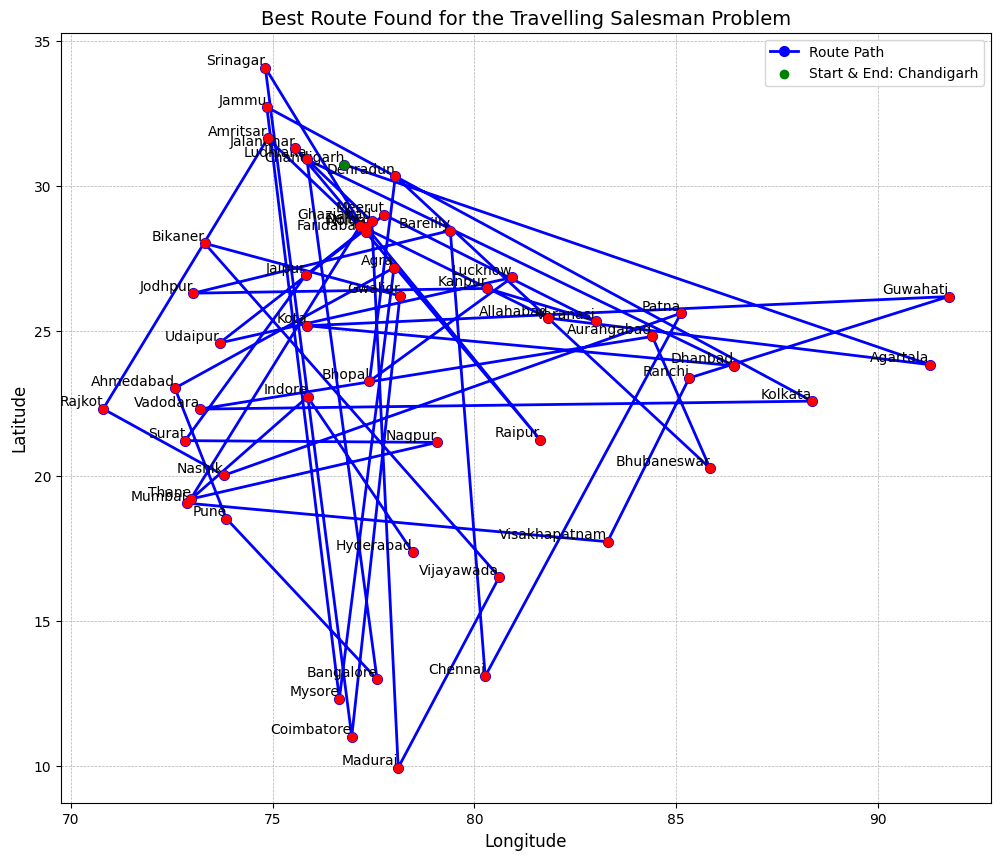

In [14]:
from matplotlib import pyplot as plt

# Adjust column names and retrieve the relevant data
city_names = city_df.index.tolist()  # Assuming 'city_df' contains city names as indices
latitudes = city_df['Latitude'].tolist()
longitudes = city_df['Longitude'].tolist()

# Retrieve the best route's coordinates in order (using the city indices from best_overall_route)
best_route_coords = [(longitudes[city[1]], latitudes[city[1]]) for city in best_overall_route]

# Separate the coordinates for plotting
x_coords, y_coords = zip(*best_route_coords)

# Plot the route
plt.figure(figsize=(12, 10))
plt.plot(x_coords, y_coords, marker='o', color='b', linestyle='-', linewidth=2, markersize=7, label='Route Path')
plt.scatter(x_coords, y_coords, color='red', zorder=5)  # Mark cities in red
plt.title('Best Route Found for the Travelling Salesman Problem', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Annotate city names with adjusted positions for better readability
for i, city in enumerate(best_overall_route):
    city_index = city[1]  # Extract index from the tuple
    plt.text(x_coords[i], y_coords[i], city_names[city_index], fontsize=10, ha='right', va='bottom', color='black')

# Highlight the start and end points (same city, so only mark it once)
start_city = best_overall_route[0][1]  # Extract index from the tuple
plt.scatter(x_coords[0], y_coords[0], color='green', zorder=6, label=f"Start & End: {city_names[start_city]}")  # Green for start/end city

# Add a legend
plt.legend(loc='best')

# Display the plot
plt.show()
